# Ramsey model with endogenous labor supply and a government

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import optimize
from copy import copy

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from RamseyModel import RamseyModelClass

## 1. <a id='toc1_'></a>[Model descripton](#toc0_)

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** Single infinitely-lived household.

**Household:** Households supply labor exogenously, $N_{t}=1$, and earns a wage $w_{t}$. The return on saving is $r_{t+1}$. Utility is 

$$
\begin{aligned}
U & =\max_{\{C_{t},N_{t}\}_{t=0}^{\infty}}\sum_{t=0}^{\infty}\beta^{t}(\frac{C_{t}^{1-\sigma}}{1-\sigma}-\varphi \frac{N_{t}^{1+\eta}}{1+\eta}),\beta\in(0,1),\sigma>0,\varphi>0,\eta>0\\
 & \text{s.t.}\\
 & M_{t}=(1+r_{t})A_{t-1}+(1-\tau_{t})w_{t}N_{t}\\
 & A_{t}=M_{t}-C_{t}
\end{aligned}
$$

where $M_{t}$ is cash-on-hand and $A_{t}$ is end-of-period assets.

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$
and hires labor $L_{t}$ at the wage rate $w_{t}$.<br>
Firms have access to the production function
    
$$
\begin{aligned}
Y_{t} &= F(K_{t-1},L_{t}) \\ &=\Gamma_t(\alpha K_{t-1}^{-\theta}+(1-\alpha)L_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1),\Gamma_t>0
\end{aligned}
$$

Profits are

$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}L_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Government:** The government levies a flat tax on labor income $\tau^L_{t}$ and uses it for wasteful spending, $G_t$. The government runs a balanced budget given by

\begin{aligned}
    G_t = \tau^L_t w_t L_t
\end{aligned}

**Equilibrium:**

1. Households maximize utility
2. Firms maximize profits
3. Labor market clear: $L_{t}=N_{t}$
4. Goods market clear: $Y_{t}=C_{t}+I_{t} + G_t$
5. Asset market clear: $A_{t}=K_{t}$ and $r_{t}=r_{t}^{k}-\delta$
6. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_{t}^{k} & = F_{K}(K_{t-1},L_{t})=\Gamma_t \alpha K_{t-1}^{-\theta-1}Y_{t}^{-1}\\
w_{t} & = F_{L}(K_{t-1},L_{t})=\Gamma_t (1-\alpha)L_{t}^{-\theta-1}Y_{t}^{-1}
\end{aligned}
$$

**Implication of utility maximization:** From FOCs

$$
\begin{aligned}
C_{t}^{-\sigma}&=\beta(1+r_{t+1})C_{t+1}^{-\sigma} \\
&=\beta(1+F_{K}(K_{t},L_{t+1})-\delta)C_{t+1}^{-\sigma}
\end{aligned}
$$

**Simpler capital accumulation equation:** 

$$
\begin{aligned}
K_{t} &= (1-\delta)K_{t-1}+I_{t} \\
&= (1-\delta)K_{t-1}+Y_{t}-C_{t} \\
&= (1-\delta)K_{t-1} + F(K_{t-1},L_{t})-C_{t}
\end{aligned}
$$

## 2. <a id='toc2_'></a>[Solution](#toc0_)

**Solution algorithm:** 

We can summarize the model in the **non-linear equation system**

$$
\begin{aligned}
\boldsymbol{H}(\boldsymbol{K},\boldsymbol{C},K_{-1})=\left[\begin{array}{c}
H_{0}\\
H_{1}\\
\begin{array}{c}
\vdots\end{array}
\end{array}\right]=\left[\begin{array}{c}
0\\
0\\
\begin{array}{c}
\vdots\end{array}
\end{array}\right]
\end{aligned}
$$

where $\boldsymbol{K} = [K_0,K_1\dots]$, $\boldsymbol{C} = [C_0,C_1\dots]$, and

$$
\begin{aligned}
H_{t}
=\left[\begin{array}{c}
C_{t}^{-\sigma}-\beta(1+r_{t+1})C_{t+1}^{-\sigma}\\
K_{t}-[(1-\delta)K_{t-1} + Y_t - C_{t} - G_{t}]\\
N_{t}-\left(\frac{w_t}{\varphi} \right)^{\frac{1}{\eta}} C_t^{\frac{-\sigma}{\eta}}]
\end{array}\right],
\end{aligned}
$$
where the last equation is the FOC for labor supply, also stated below:
\begin{align*}
    \frac{\partial U}{\partial N_t} &= C_t^{-\sigma} \cdot (1-\tau_t) w_t - \varphi N_t^\eta = 0 \\
\end{align*}

**Implementation:** Assume all variables are in steady  state after some **truncation horizon**.<br>We solve equation system above in **two steps**:

1. Calculate the numerical **jacobian** of $\boldsymbol{H}$ wrt. $\boldsymbol{K}$
, $\boldsymbol{C}$, and $\boldsymbol{N}$ around the steady state
2. Solve the equation system using a **hand-written Broyden-solver**

In [2]:
model = RamseyModelClass()
par = model.par
ss = model.ss
path = model.path

initializing the model:
calling .setup()
calling .allocate()


**Find steady state:** 

The steady state is found by solving the equation system above algebraically, assuming that all variables are in steady state such that variable $X_{t-1} = X_{t} = X_{t+1} = X_{ss}$ for all $X$. 

1. Target steady-state capital-output ratio, $K_{ss}/L_{ss}$ of 4.0.
2. Force steady-state output per worker $Y_{ss}/L_{ss} = 1$.
3. Adjust $\beta$ and $\Gamma_{ss}$ to achieve this.

Note that I solve the model using a CES production function, and apply that 
\begin{align*}
    \frac{Y_t}{L_t} &= \Gamma_t \left( \alpha \left(\frac{K_{t-1}}{L_t}\right)^{-\theta} + (1-\alpha) \right)^{\frac{1}{-\theta}} \\
\end{align*}

In [3]:
model.find_steady_state(KL_ss=4.0)

Y_ss = 1.0783
K_ss = 4.3132
L_ss = 1.0783
K_ss/Y_ss = 4.0000
rk_ss = 0.0714
r_ss = 0.0214
w_ss = 0.7144
Gamma = 0.6664
beta = 0.9790
G = 0.1078
tax rate = 0.1400
tax revenue= 0.1078
capital markets clear = -0.0000
euler error = 0.0000


Let's investigate what happens if the disutility of work $varphi$ is increased to 2.

In [4]:
model_alt = RamseyModelClass()
model_alt.par.phi = 2.0
model_alt.find_steady_state(KL_ss=4.0)

initializing the model:
calling .setup()
calling .allocate()
Y_ss = 0.8558
K_ss = 3.4234
L_ss = 0.8558
K_ss/Y_ss = 4.0000
rk_ss = 0.0714
r_ss = 0.0214
w_ss = 0.7144
Gamma = 0.6664
beta = 0.9790
G = 0.0856
tax rate = 0.1400
tax revenue= 0.0856
capital markets clear = -0.0000
euler error = 0.0000


I see that output, labor supply and capital goes down in the steady state. The intuition is that workers are less willing to work, so firms will produce less, and therefore demand less capital. The capital-output ratio is unchanged, as the decrease in capital is proportional to the decrease in output.

**Test that errors and the path are 0:**

In [5]:
# a. set initial value
par.K_lag_ini = ss.K

# b. set path
path.Gamma[:] = ss.Gamma
path.C[:] = ss.C
path.K[:] = ss.K
path.L[:] = ss.L
path.tau_L[:] = ss.tau_L
path.G[:] = ss.G
path.xi[:] = ss.xi

# c. check errors
errors_ss = model.evaluate_path_errors()
print(errors_ss)
assert np.allclose(errors_ss,0.0)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.22044605e-16
 2.22044605e-16 2.22044605e-16]


In [6]:
model.calculate_jacobian()

In [7]:
model_backup = copy(model)

**Solve:**

I solve the transition path using a broyden root finder, to ensure that all errors are zero.

Broyden's method is a quasi-Newton method, which is a generalization of Newton's method. The method is used to find the root of a function $f(x) = 0$. The difference between Brodyen's method and Newton's method is that the Jacobian is approximated by an updating algorithm instead of being calculated analytically. The matrix is updated at each iteration, and the method converges to the root of the function. I will not go over the details of the method, but instead describe the basics of Newton's method.

Newton's method uses the first order Taylor expansion of a function $f(x)$ around a point $x_0$ to approximate the function. The new guess is then updated using this formula.
\begin{align*}
    f(x) &= f(x_0) + f'(x_0)(x-x_0) \\
    x &= x_0 - \frac{f(x_0)}{f'(x_0)} \\
\end{align*}

In [8]:
par.K_lag_ini = 0.50*ss.K # start away from steady state
model.solve() # find transition path

 it =   0 -> max. abs. error =   2.24464162
 it =   1 -> max. abs. error =   0.05546321
 it =   2 -> max. abs. error =   0.04080373
 it =   3 -> max. abs. error =   0.00795411
 it =   4 -> max. abs. error =   0.00554291
 it =   5 -> max. abs. error =   0.00363696
 it =   6 -> max. abs. error =   0.00051465
 it =   7 -> max. abs. error =   0.00049878
 it =   8 -> max. abs. error =   0.00017076
 it =   9 -> max. abs. error =   0.00003635
 it =  10 -> max. abs. error =   0.00000514
 it =  11 -> max. abs. error =   0.00000254
 it =  12 -> max. abs. error =   0.00000012
 it =  13 -> max. abs. error =   0.00000006
 it =  14 -> max. abs. error =   0.00000001


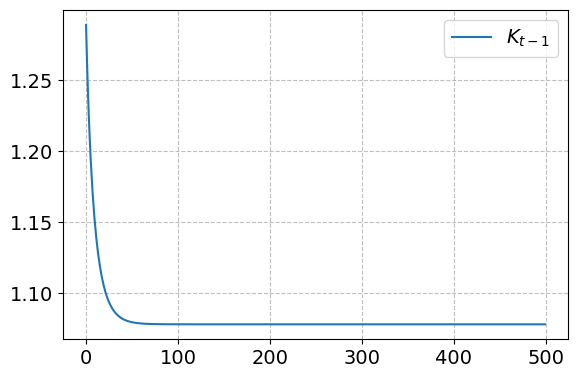

In [9]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(path.L,label=r'$K_{t-1}$')
ax.legend(frameon=True)
fig.tight_layout()

## 5. <a id='toc5_'></a>[Future persistent government expenditure](#toc0_)

**Shock happing after period $J$:**

In [10]:
par.K_lag_ini = ss.K # start from steady state

# shock
J = 50
path.G[:] = ss.G
path.G[J:] = ss.G + 0.95**np.arange(par.Tpath-J)*0.01*ss.Y

**Solve:**

In [11]:
model.solve()

 it =   0 -> max. abs. error =   0.01755187
 it =   1 -> max. abs. error =   0.00014560
 it =   2 -> max. abs. error =   0.00000062
 it =   3 -> max. abs. error =   0.00000000


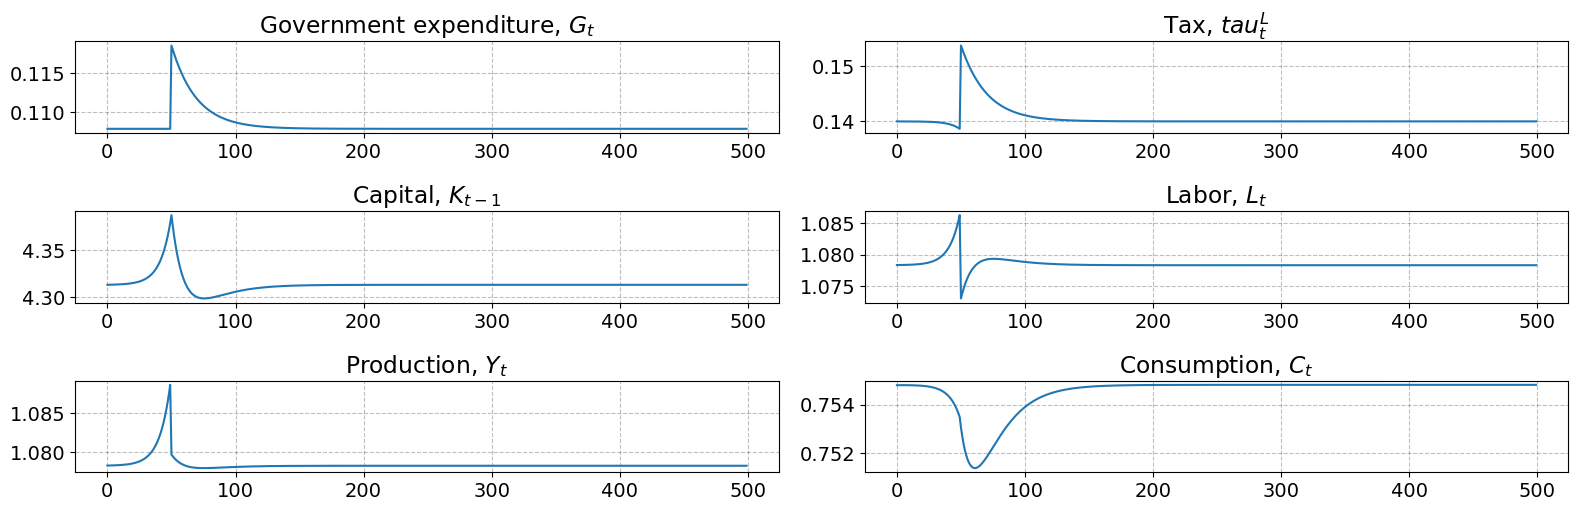

In [12]:
fig = plt.figure(figsize=(2*8,8/1.5))

ax = fig.add_subplot(3,2,1)
ax.plot(path.G)
ax.set_title('Government expenditure, $G_t$')

ax = fig.add_subplot(3,2,2)
ax.plot(path.tau_L)
ax.set_title('Tax, $tau^L_t$')

ax = fig.add_subplot(3,2,3)
ax.plot(path.K_lag)
ax.set_title('Capital, $K_{t-1}$')

ax = fig.add_subplot(3,2,4)
ax.plot(path.L)
ax.set_title('Labor, $L_t$')

ax = fig.add_subplot(3,2,5)
ax.plot(path.Y)
ax.set_title('Production, $Y_{t}$')

ax = fig.add_subplot(3,2,6)
ax.plot(path.C)
ax.set_title('Consumption, $C_t$')

fig.tight_layout()

In [13]:
oldpath = copy(path)

## 6. <a id='toc5_'></a>[Extension: Adding transfers](#toc0_)

**Household:** Households supply labor exogenously, $N_{t}=1$, and earns a wage $w_{t}$. The return on saving is $r_{t+1}$. Utility is 

$$
\begin{aligned}
U & =\max_{\{C_{t},N_{t}\}_{t=0}^{\infty}}\sum_{t=0}^{\infty}\beta^{t}(\frac{C_{t}^{1-\sigma}}{1-\sigma}-\varphi \frac{N_{t}^{1+\eta}}{1+\eta}),\beta\in(0,1),\sigma>0,\varphi>0,\eta>0\\
 & \text{s.t.}\\
 & M_{t}=(1+r_{t})A_{t-1}+(1-\tau_{t})w_{t}N_{t} + \xi_t\\
 & A_{t}=M_{t}-C_{t}
\end{aligned}
$$

where $M_{t}$ is cash-on-hand and $A_{t}$ is end-of-period assets.

**Government:** The government levies a flat tax on labor income $\tau^L_{t}$ and uses it for wasteful spending, $G_t$, and transfers to the households, $\xi_t$. The government budget constraint is

\begin{aligned}
    G_t + \xi_t= \tau^L_t w_t L_t
\end{aligned}

In [14]:
model = model_backup
par = model.par
ss = model.ss
path = model.path

**Shock happing after period $J$:**

In [15]:
par.K_lag_ini = ss.K # start from steady state

# shock
J = 50
path.xi[:] = ss.xi
path.xi[J:] = ss.xi + 0.95**np.arange(par.Tpath-J)*0.01*ss.Y

**Solve:**

In [16]:
model.solve()

 it =   0 -> max. abs. error =   0.03510374
 it =   1 -> max. abs. error =   0.00068487
 it =   2 -> max. abs. error =   0.00000433
 it =   3 -> max. abs. error =   0.00000003
 it =   4 -> max. abs. error =   0.00000000


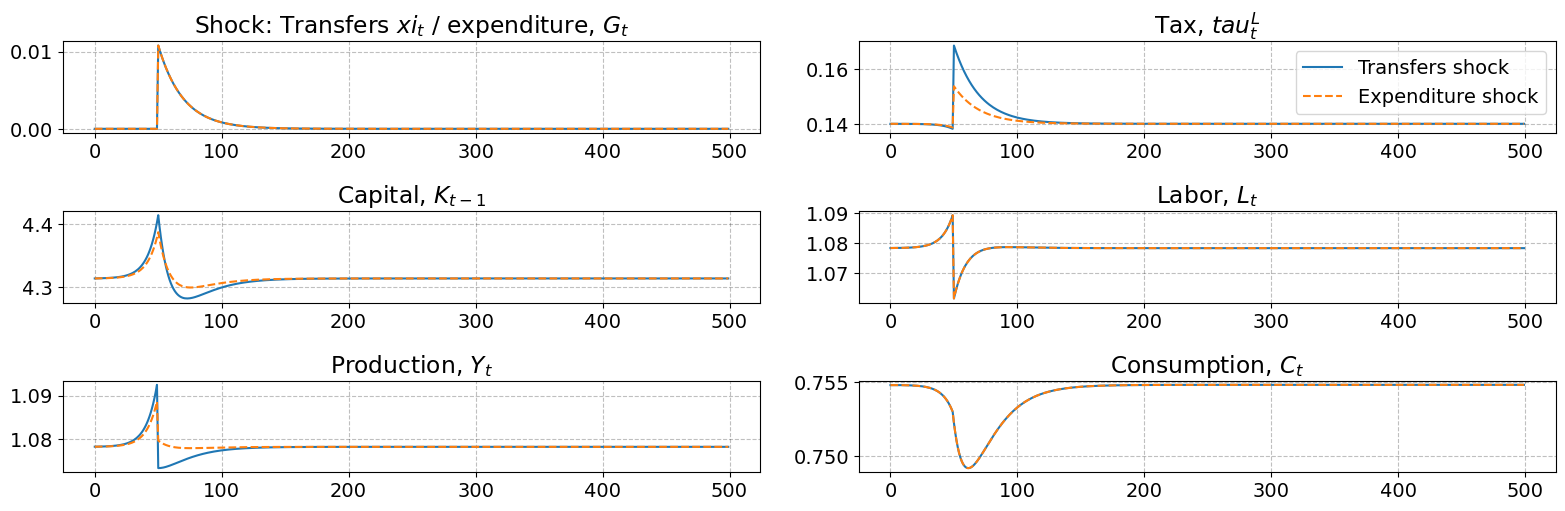

In [17]:
fig = plt.figure(figsize=(2*8,8/1.5))

ax = fig.add_subplot(3,2,1)
ax.plot(path.xi-ss.xi)
ax.plot(oldpath.G - ss.G, linestyle='--')
ax.set_title('Shock: Transfers $xi_t$ / expenditure, $G_t$')

ax = fig.add_subplot(3,2,2)
ax.plot(path.tau_L)
ax.plot(oldpath.tau_L, linestyle='--')
ax.set_title('Tax, $tau^L_t$')
ax.legend(['Transfers shock','Expenditure shock'])

ax = fig.add_subplot(3,2,3)
ax.plot(path.K_lag)
ax.plot(oldpath.K_lag, linestyle='--')
ax.set_title('Capital, $K_{t-1}$')

ax = fig.add_subplot(3,2,4)
ax.plot(path.L)
ax.plot(oldpath.L, linestyle='--')
ax.set_title('Labor, $L_t$')

ax = fig.add_subplot(3,2,5)
ax.plot(path.Y)
ax.plot(oldpath.Y, linestyle='--')
ax.set_title('Production, $Y_{t}$')

ax = fig.add_subplot(3,2,6)
ax.plot(path.C)
ax.plot(oldpath.C, linestyle='--')
ax.set_title('Consumption, $C_t$')

fig.tight_layout()

The shock to the government balance is identical across the two models, so the only difference is how the government spends the money. When the government increase expenditure it crowds out private consumption but not one-to-one. When the shock hits, the government taxes labor income to finance its expenditure. The households responds by working and consuming less. The households also save less, as they have less income. The households are worse off, as they have less consumption and leisure. Before the shock hits, household respond by increasing savings, as they expect to be taxed in the future. This increases capital and output, which increases labor demand. Consumption doesn't increase before the shock because the extra income is being saved.

The transfers shock is very similar to the expenditure shock. The households are worse off, as they have less consumption and leisure. Before the shock hits, household respond by increasing savings, as they expect to receive transfers in the future. However, because the taxed income isn't used for wasteful spending, but given to the households, some of it will be saved. This means that the demand in the economy is relatively lower and so are income. To finance the shock, the government has to tax labor income harder. The households expect this and save even more before the shock hits, increasing capital and output before the shock. Interestingly the response in labor and consumption is identical across the two specifications, because after-tax income is the same.